In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, StackingRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

from sklearn.pipeline import Pipeline

import tensorflow as tf
import keras

import joblib

In [2]:
df = pd.read_csv('crop_yield.csv')
df.head()

,Crop,Precipitation,SpecificHumidity_g_kg,RelativeHumidity_%,Temperature_C,Yield
0,"Cocoa, beans",2248.92,17.72,83.40,26.01,11560
1,"Cocoa, beans",1938.42,17.54,82.11,26.11,11253
2,"Cocoa, beans",2301.54,17.81,82.79,26.24,9456
3,"Cocoa, beans",2592.35,17.61,85.07,25.56,9321
4,"Cocoa, beans",2344.72,17.61,84.12,25.76,8800


### Pré-Processamento dos dados

Como já realizamos a análise exploratória dos dados, podemos partir para a preparação dos dados para o algoritmo de Machine Learning.

**Tratamento dos dados categóricos**

O parâmetro *drop-first=True* serve para evitar multicolinearidade entre os dados, ou seja, variáveis que se correlacionam entre si.

In [3]:
crop = pd.get_dummies(df, columns=['Crop'], drop_first=True)
df = pd.concat([df['Crop'], crop], axis=1)
df.head()

,Crop,Precipitation,SpecificHumidity_g_kg,RelativeHumidity_%,Temperature_C,Yield,Crop_Oil palm fruit,"Crop_Rice, paddy","Crop_Rubber, natural"
0,"Cocoa, beans",2248.92,17.72,83.40,26.01,11560,False,False,False
1,"Cocoa, beans",1938.42,17.54,82.11,26.11,11253,False,False,False
2,"Cocoa, beans",2301.54,17.81,82.79,26.24,9456,False,False,False
3,"Cocoa, beans",2592.35,17.61,85.07,25.56,9321,False,False,False
4,"Cocoa, beans",2344.72,17.61,84.12,25.76,8800,False,False,False


**Combinação das 2 features de humidade**

In [4]:
df['HumidityCombined'] = df['RelativeHumidity_%'] * df['SpecificHumidity_g_kg'] # Combinação das features

#df.drop(['SpecificHumidity_g_kg', 'RelativeHumidity_%'], axis=1, inplace=True) # Excluindo valores de humidade anteriores
df.head()

,Crop,Precipitation,SpecificHumidity_g_kg,RelativeHumidity_%,Temperature_C,Yield,Crop_Oil palm fruit,"Crop_Rice, paddy","Crop_Rubber, natural",HumidityCombined
0,"Cocoa, beans",2248.92,17.72,83.40,26.01,11560,False,False,False,1477.8480
1,"Cocoa, beans",1938.42,17.54,82.11,26.11,11253,False,False,False,1440.2094
2,"Cocoa, beans",2301.54,17.81,82.79,26.24,9456,False,False,False,1474.4899
3,"Cocoa, beans",2592.35,17.61,85.07,25.56,9321,False,False,False,1498.0827
4,"Cocoa, beans",2344.72,17.61,84.12,25.76,8800,False,False,False,1481.3532


**Separando variáveis independentes (X) da variável dependente (y)**

In [5]:
df['Yield_log'] = np.log1p(df['Yield'])

In [6]:
X = df[['Crop','Crop_Oil palm fruit', 'Crop_Rice, paddy', 'Precipitation', 'HumidityCombined', 'Temperature_C']]
#y = df['Yield']
y = df['Yield_log']

**Separação dos dados em treino e teste**

Método HoldOut, porém também faremos validação cruzada.

É realizado uma **estratificação** pela cultura (Crop) para cada exemplo.

In [7]:
SEED = 80

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=X['Crop'], random_state=SEED)

X_train['Crop'].value_counts()

Crop
Cocoa, beans       31
Rubber, natural    31
Rice, paddy        31
Oil palm fruit     31
Name: count, dtype: int64

In [8]:
X_test['Crop'].value_counts()

Crop
Cocoa, beans       8
Rubber, natural    8
Rice, paddy        8
Oil palm fruit     8
Name: count, dtype: int64

In [9]:
X_train.drop('Crop', axis=1, inplace=True)
X_test.drop('Crop', axis=1, inplace=True)
X.drop('Crop', axis=1, inplace=True)

C:\Users\DIOGO-PC\AppData\Local\Temp\ipykernel_3352\152154555.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop('Crop', axis=1, inplace=True)


**Normalização**

In [10]:
normalization = StandardScaler()

X_train_scaled = normalization.fit_transform(X_train)
X_test_scaled = normalization.transform(X_test)

### Treinamento com vários modelos

In [11]:
def view_scores(y_true, y_pred, title):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(title)
    print(f'MSE: {mse}')
    print(f'RMSE: {np.sqrt(mse)}')
    print(f'R² Score: {r2*100:.2f}')

In [12]:
def cros_validate_view_scores(results):
   mse_scores = -results['test_neg_mean_squared_error'].mean() # Realiza a média e converte para valores positivos
   r2_scores = results['test_r2'].mean() # Realiza a média e converte para valores positivos
   
   print(f'MSE: {mse_scores}')
   print(f'RMSE: {np.sqrt(mse_scores)}')
   print(f'R²: {r2_scores}')

In [13]:
kfold = KFold(n_splits=10, shuffle=True, random_state=SEED)

#### Modelo Baseline

In [14]:
model_lr = LinearRegression()
model_lr.fit(X_train_scaled, y_train)

model_lr_predict = model_lr.predict(X_test_scaled)
view_scores(y_test, model_lr_predict, 'Modelo Baseline (Logistic Regression)')

Modelo Baseline (Logistic Regression)
MSE: 0.023931103915496486
RMSE: 0.15469681288086218
R² Score: 98.59


**Validação cruzada**

OBS: Para problemas de regressão, é necessário utilizar o KFold.

In [15]:
pipeline_lr = Pipeline([
    ('scaler', MinMaxScaler()),
    ('estimator', LinearRegression())
])

results_lr = cross_validate(pipeline_lr, X, y,
                            cv=kfold,
                            scoring=['neg_mean_squared_error', 'r2'])
cros_validate_view_scores(results_lr)

MSE: 0.029838947716696505
RMSE: 0.17273953721339103
R²: 0.9791951234751484


#### Voting Regressor

In [16]:
base_models = [
    ('dt', DecisionTreeRegressor(random_state=SEED)),
    ('rt', RandomForestRegressor(n_estimators=100, random_state=SEED)),
    ('knn', KNeighborsRegressor()),
    ('svc', SVR()),
    ('lr', LinearRegression())
]

model_bg = VotingRegressor(estimators=base_models)
model_bg.fit(X_train_scaled, y_train)

model_bg_predict = model_bg.predict(X_test_scaled)
view_scores(y_test, model_bg_predict, 'Voting Regressor')

Voting Regressor
MSE: 0.032083644548481595
RMSE: 0.1791190792419434
R² Score: 98.11


**Validação Cruzada**

In [17]:
pipeline_vt = Pipeline([
    ('scaler', MinMaxScaler()),
    ('estimator', VotingRegressor(estimators=base_models))
])

results_vt = cross_validate(pipeline_vt, X, y,
                            cv=kfold,
                            scoring=['neg_mean_squared_error', 'r2'])
cros_validate_view_scores(results_vt)

MSE: 0.0261696628563174
RMSE: 0.16177040166951864
R²: 0.9820594267981206


#### Stacking

In [18]:
model_st = StackingRegressor(estimators=base_models,
                             final_estimator=DecisionTreeRegressor(random_state=SEED))
model_st.fit(X_train_scaled, y_train)

model_st_predict = model_st.predict(X_test_scaled)
view_scores(y_test, model_st_predict, 'Stacking')

Stacking
MSE: 0.05473184579313621
RMSE: 0.23394838275383784
R² Score: 96.78


**Validação Cruzada**

In [19]:
pipeline_stc = Pipeline([
    ('scaler', MinMaxScaler()),
    ('estimator', StackingRegressor(estimators=base_models,
                             final_estimator=DecisionTreeRegressor(random_state=SEED)))
])

results_stc = cross_validate(pipeline_stc, X, y,
                            cv=kfold,
                            scoring=['neg_mean_squared_error', 'r2'])
cros_validate_view_scores(results_stc)

MSE: 0.048506463220220765
RMSE: 0.22024182895222416
R²: 0.9662817116950887


#### Floresta Aleatória

In [20]:
model_rf = RandomForestRegressor(random_state=SEED)
model_rf.fit(X_train, y_train)

model_rf_predict = model_rf.predict(X_test)
view_scores(y_test, model_rf_predict, 'Floresta Aleatória')

Floresta Aleatória
MSE: 0.02391433880120008
RMSE: 0.15464261638112595
R² Score: 98.59


**Validação Cruzada**

In [21]:
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('estimator', RandomForestRegressor(random_state=SEED))
])

results_rf = cross_validate(pipeline_rf, X, y,
                            cv=kfold,
                            scoring=['neg_mean_squared_error', 'r2'])
cros_validate_view_scores(results_rf)

MSE: 0.02815968446620586
RMSE: 0.167808475549377
R²: 0.980844573424358


#### Bagging Regressor

In [22]:
model_bg = BaggingRegressor(estimator=LinearRegression(), random_state=SEED)
model_bg.fit(X_train_scaled, y_train)

model_bg_predict = model_bg.predict(X_test_scaled)
view_scores(y_test, model_bg_predict, 'Bagging Regressor')

Bagging Regressor
MSE: 0.024181626753516365
RMSE: 0.1555044267971699
R² Score: 98.58


**Validação Cruzada**

In [23]:
pipeline_bg = Pipeline([
    ('scaler', MinMaxScaler()),
    ('estimator', BaggingRegressor(estimator=LinearRegression(), random_state=SEED))
])

results_bg = cross_validate(pipeline_bg, X, y,
                            cv=kfold,
                            scoring=['neg_mean_squared_error', 'r2'])
cros_validate_view_scores(results_bg)

MSE: 0.030086946893100958
RMSE: 0.17345589322101732
R²: 0.9790005777025834


#### XGBoost

In [24]:
model_xgb = XGBRegressor()
model_xgb.fit(X_train_scaled, y_train)

model_xgb_predict = model_xgb.predict(X_test_scaled)
view_scores(y_test, model_xgb_predict, 'XGBoost Regressor')

XGBoost Regressor
MSE: 0.0366137835346261
RMSE: 0.19134728515091637
R² Score: 97.85


**Validação Cruzada**

In [25]:
pipeline_xgb = Pipeline([
    ('scaler', MinMaxScaler()),
    ('estimator', XGBRegressor())
])

results_xgb = cross_validate(pipeline_xgb, X, y,
                            cv=kfold,
                            scoring=['neg_mean_squared_error', 'r2'])
cros_validate_view_scores(results_xgb)

MSE: 0.04038337834050154
RMSE: 0.2009561602452175
R²: 0.973087275214269


#### Redes Neurais

Apesar de redes neurais serem poderosas, nem sempre é a melhor escolha.

In [26]:
model_keras = keras.Sequential([
    keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='linear')
])

c:\Users\DIOGO-PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
model_keras.compile(optimizer=keras.optimizers.Adam(),
                    loss=keras.losses.MeanSquaredError(),
                    metrics=[keras.metrics.R2Score(), keras.metrics.RootMeanSquaredError()])

model_keras.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,313 (177.00 KB)

 Trainable params: 45,313 (177.00 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
             keras.callbacks.ModelCheckpoint(monitor='val_loss',
                                             filepath='checkpoint_best_model.keras', save_best_only=True)]

In [29]:
history = model_keras.fit(X_train_scaled, y_train,
                epochs=150,
                batch_size=32,
                validation_data=(X_test_scaled, y_test),
                callbacks=callbacks)

Epoch 1/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 101.8429 - r2_score: -61.3042 - root_mean_squared_error: 10.0905 - val_loss: 96.1741 - val_r2_score: -55.5074 - val_root_mean_squared_error: 9.8068
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 94.1677 - r2_score: -62.9818 - root_mean_squared_error: 9.7038 - val_loss: 85.5035 - val_r2_score: -49.2379 - val_root_mean_squared_error: 9.2468
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 82.6489 - r2_score: -49.9995 - root_mean_squared_error: 9.0908 - val_loss: 68.9561 - val_r2_score: -39.5154 - val_root_mean_squared_error: 8.3040
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 66.2741 - r2_score: -38.9930 - root_mean_squared_error: 8.1384 - val_loss: 46.3636 - val_r2_score: -26.2411 - val_root_mean_squared_error: 6.8091
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 44.1676 - r2_score: -26.3769 - root_mean_squared_error: 6.6357 - val_loss: 20.8147 - val_r2_score: -11.2298 - val_root_mean_

In [30]:
predict_keras_train = model_keras.predict(X_train_scaled)
predict_keras_test = model_keras.predict(X_test_scaled)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [31]:
history.history.keys()

dict_keys(['loss', 'r2_score', 'root_mean_squared_error', 'val_loss', 'val_r2_score', 'val_root_mean_squared_error'])

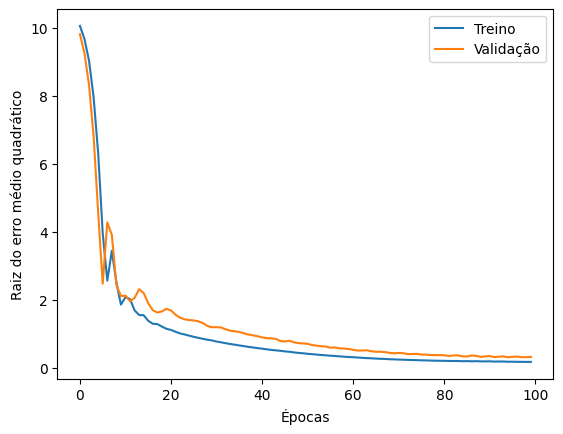

In [32]:
# MSE (RMSE) -> Quanto menor, melhor
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.xlabel('Épocas')
plt.ylabel('Raiz do erro médio quadrático')
plt.legend(['Treino','Validação'])

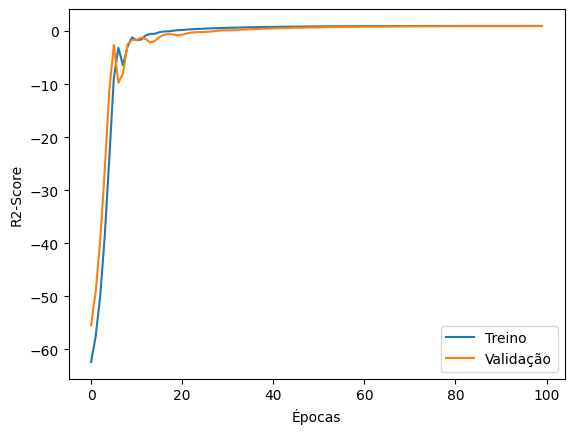

In [33]:
# R² Score -> Quanto maior, melhor
plt.plot(history.history['r2_score'])
plt.plot(history.history['val_r2_score'])
plt.xlabel('Épocas')
plt.ylabel('R2-Score')
plt.legend(['Treino','Validação'])

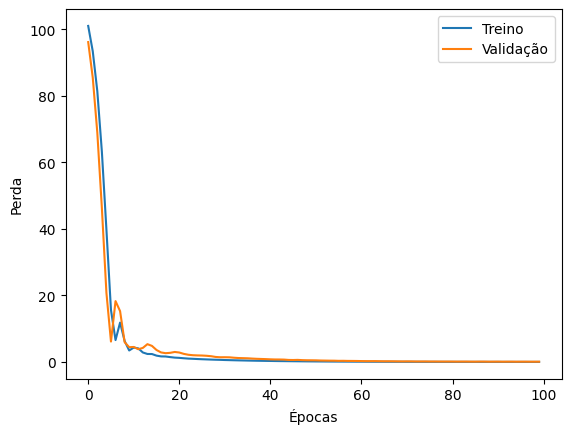

In [34]:
# Valor de perda -> Quanto menor, melhor
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend(['Treino','Validação'])

**Voltando para escala original**

In [35]:
y_train = np.expm1(y_train)
y_test = np.expm1(y_test)

predict_keras_train = np.expm1(predict_keras_train)
predict_keras_test = np.expm1(predict_keras_test)

Text(0.5, 0, 'Rendimentos')

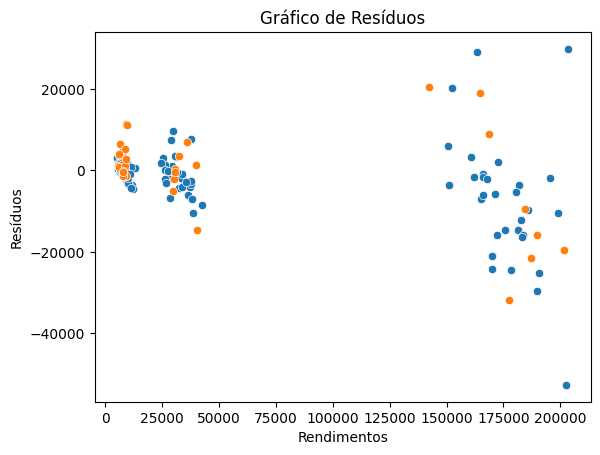

In [36]:
resid_train = predict_keras_train.reshape(-1) - y_train  # flatten() tbm funciona para reduzir as dimensões do array
resid_test = predict_keras_test.reshape(-1) - y_test

sns.scatterplot(x=y_train, y=resid_train)
sns.scatterplot(x=y_test, y=resid_test)
plt.title("Gráfico de Resíduos")
plt.ylabel("Resíduos")
plt.xlabel("Rendimentos")

**Valores esperados x valores previstos da rede neural**

<Axes: >

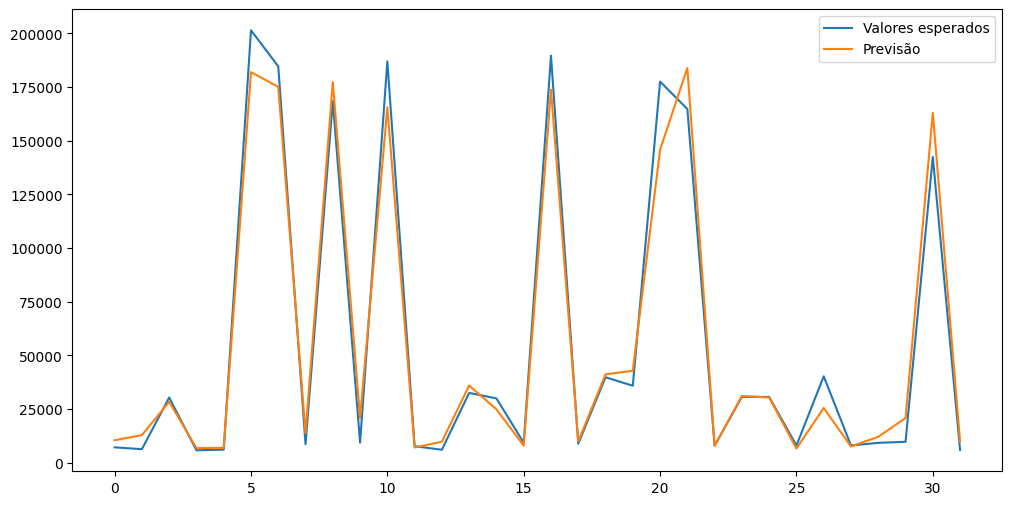

In [37]:
plt.figure(figsize=(12,6))
sns.lineplot(x=np.arange(0, len(y_test), 1), y=np.array(y_test), label='Valores esperados')
sns.lineplot(x=np.arange(0, len(y_test), 1), y=predict_keras_test.reshape(-1), label='Previsão')

### Analisando o modelo treinado com a metodologia HoldOut

**Voltar para escala original.**

In [38]:
model_rf_predict = np.expm1(model_rf_predict)

**Visualização dos resíduos**

In [39]:
rf_resid = model_rf_predict - y_test

Text(0, 0.5, 'Resíduos')

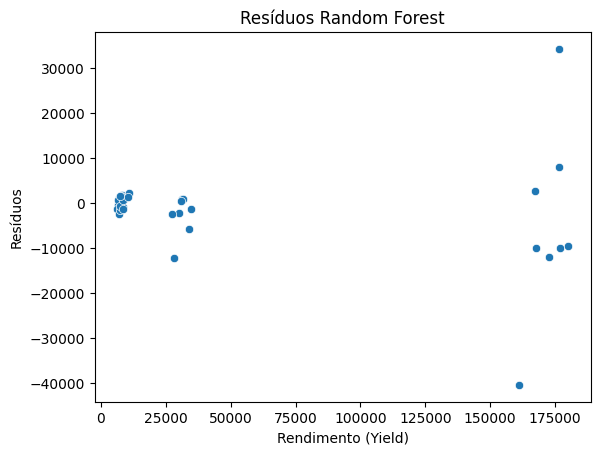

In [40]:
sns.scatterplot(x=model_rf_predict, y=rf_resid)
plt.title('Resíduos Random Forest')
plt.xlabel('Rendimento (Yield)')
plt.ylabel('Resíduos')

**Comparação de valores esperados VS valores previstos**

<Axes: >

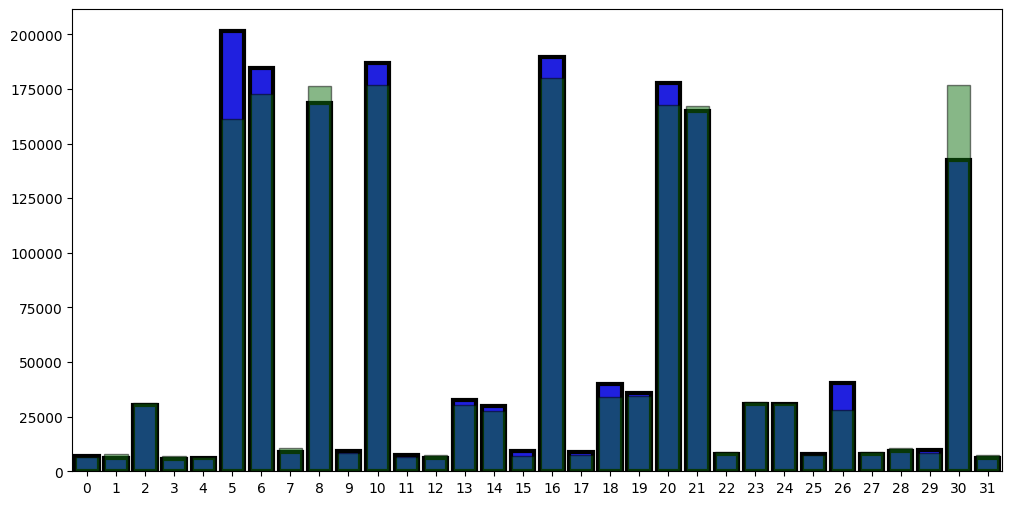

In [41]:
plt.figure(figsize=(12,6))
sns.barplot(np.array(y_test), color='blue', edgecolor='black', linewidth=3)
sns.barplot(model_rf_predict, color='green', alpha=0.5, edgecolor='black')

**Visualização dos mesmos resultados, porém com valores abaixo de 50 mil.**

Text(0.5, 0, 'Colheitas')

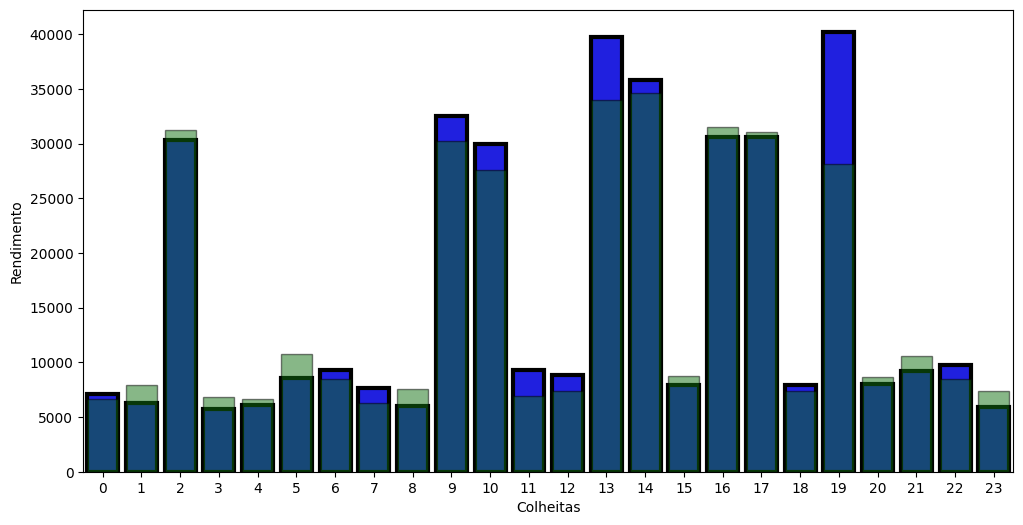

In [42]:
plt.figure(figsize=(12,6))
sns.barplot(np.array(y_test[y_test < 50000]), color='blue', edgecolor='black', linewidth=3)
sns.barplot(np.array(model_rf_predict[model_rf_predict < 50000]), color='green', alpha=0.5, edgecolor='black')
plt.ylabel('Rendimento')
plt.xlabel('Colheitas')

**Mesma visualização, porém com um gráfico de dispersão e em seguida um gráfico de linhas**

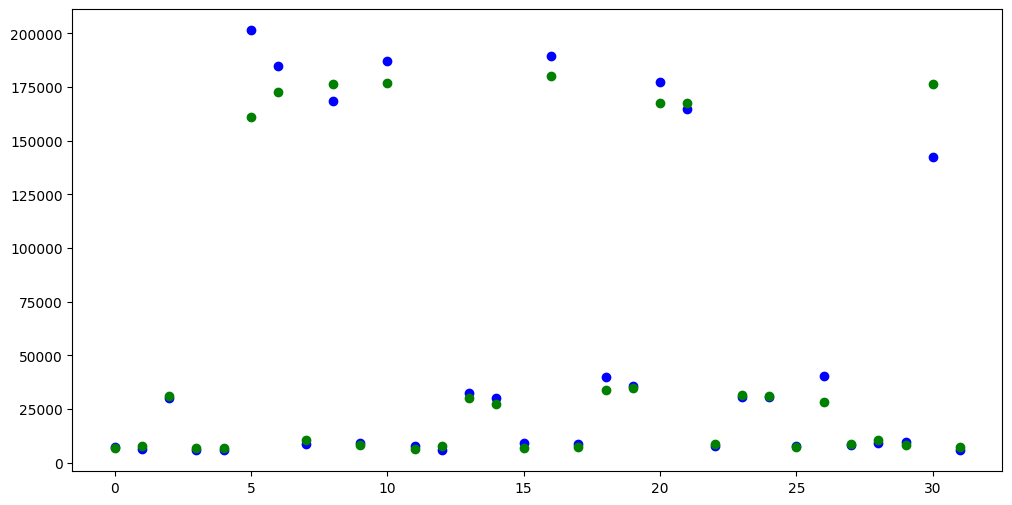

In [43]:
plt.figure(figsize=(12,6))
plt.scatter(range(len(y_test)), y_test, color='blue')
plt.scatter(range(len(y_test)), model_rf_predict, color='green')

<Axes: >

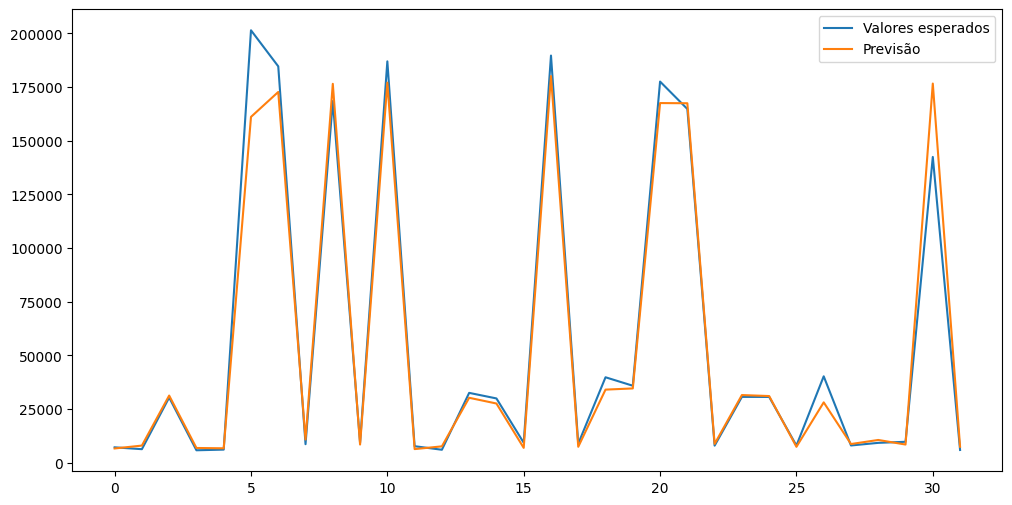

In [44]:
plt.figure(figsize=(12,6))
sns.lineplot(x=np.arange(0, len(y_test), 1), y=np.array(y_test), label='Valores esperados')
sns.lineplot(x=np.arange(0, len(y_test), 1), y=model_rf_predict, label='Previsão')

**Verificando como o modelo esta se ajustando aos dados de treinamento**

In [45]:
model_rf_predict_train = model_rf.predict(X_train)
model_rf_predict_train = np.expm1(model_rf_predict_train)

<Axes: >

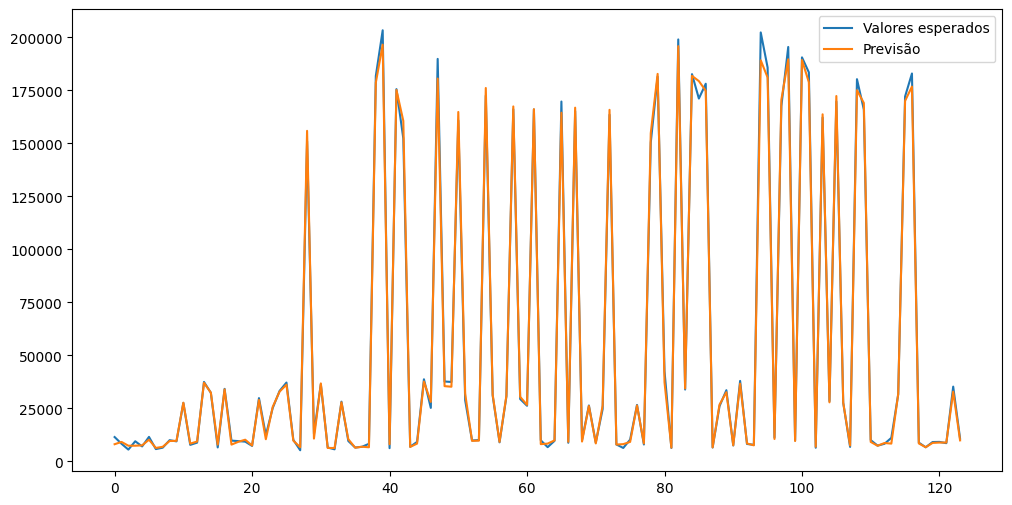

In [46]:
plt.figure(figsize=(12,6))
sns.lineplot(x=np.arange(0, len(y_train), 1), y=np.array(y_train), label='Valores esperados')
sns.lineplot(x=np.arange(0, len(y_train), 1), y=model_rf_predict_train, label='Previsão')

### Analisando os Outliers na variável alvo *Yield*

Uma coisa que deixamos de lado até o momento são os outliers presentes na variável alvo, onde praticamente todos os dados da categoria (cultura) Oil Palm Fruit são outliers. Porém, remover todos esses outliers poderia remover informações importantes do comportamento desta cultura específica.

**O que os outliers influenciaram no modelo?**
- Nos gráficos de valores reais x valores previstos, essa discrepância entre as culturas com valores de rendimentos baixos e altos resultou em **previsões ruins para rendimentos menores** e **grandes erros para rendimentos maiores**.
- Tentamos reduzir a escala da variável de rendimento com um logarítmo, porém, reescalando os dados ao estado original com *np.expm1*, o gráfico se mostrou o mesmo, com grandes erros para rendimentos maiores e previsões imprecisas para rendimentos menores.

**Possível solução:**
- Criar 2 modelos, um para prever dados de rendimentos baixos, e outro para prever dados de rendimentos altos.
- Baseado no tipo de cultura, podemos encaminhar a previsão para o modelo correto.

**Preparando dados com rendimentos baixos (Yield <= 50000)**

In [47]:
df_low_values = df.query('Yield <= 50000').copy()
df_low_values['Crop'].value_counts()

Crop
Cocoa, beans       39
Rice, paddy        39
Rubber, natural    39
Name: count, dtype: int64

In [48]:
df_low_values.drop(['Crop_Oil palm fruit', 'Crop_Rice, paddy', 'Crop_Rubber, natural'], axis=1, inplace=True)
df_low_values.head()

,Crop,Precipitation,SpecificHumidity_g_kg,RelativeHumidity_%,Temperature_C,Yield,HumidityCombined,Yield_log
0,"Cocoa, beans",2248.92,17.72,83.40,26.01,11560,1477.8480,9.355393
1,"Cocoa, beans",1938.42,17.54,82.11,26.11,11253,1440.2094,9.328479
2,"Cocoa, beans",2301.54,17.81,82.79,26.24,9456,1474.4899,9.154510
3,"Cocoa, beans",2592.35,17.61,85.07,25.56,9321,1498.0827,9.140132
4,"Cocoa, beans",2344.72,17.61,84.12,25.76,8800,1481.3532,9.082621


In [49]:
aux = pd.get_dummies(df_low_values)
df_low_values = pd.concat([df_low_values, aux[['Crop_Cocoa, beans', 'Crop_Rice, paddy', 'Crop_Rubber, natural']]], axis=1)

In [50]:
df_low_values.head()

,Crop,Precipitation,SpecificHumidity_g_kg,RelativeHumidity_%,Temperature_C,Yield,HumidityCombined,Yield_log,"Crop_Cocoa, beans","Crop_Rice, paddy","Crop_Rubber, natural"
0,"Cocoa, beans",2248.92,17.72,83.40,26.01,11560,1477.8480,9.355393,True,False,False
1,"Cocoa, beans",1938.42,17.54,82.11,26.11,11253,1440.2094,9.328479,True,False,False
2,"Cocoa, beans",2301.54,17.81,82.79,26.24,9456,1474.4899,9.154510,True,False,False
3,"Cocoa, beans",2592.35,17.61,85.07,25.56,9321,1498.0827,9.140132,True,False,False
4,"Cocoa, beans",2344.72,17.61,84.12,25.76,8800,1481.3532,9.082621,True,False,False


In [51]:
# Adquirindo variáveis para o caso de rendimentos com valores baixos
X_low_values = df_low_values[['Crop', 'Crop_Rubber, natural', 'Crop_Rice, paddy', 'Precipitation', 'HumidityCombined', 'Temperature_C']].copy()
y_low_values = df_low_values['Yield']

# Utilizando coluna Crop apenas para estratificar os dados baseado na cultura
X_train_low_values, X_test_low_values, y_train_low_values, y_test_low_values = train_test_split(X_low_values, y_low_values, test_size=0.2, stratify=X_low_values['Crop'], random_state=SEED)

# Removendo coluna Crop dos dados de treinamento e teste originais
X_train_low_values.drop('Crop', axis=1, inplace=True)
X_test_low_values.drop('Crop', axis=1, inplace=True)
X_low_values.drop('Crop', axis=1, inplace=True)

#### Treinando modelo para prever valores **baixos** de rendimento

In [52]:
model_rf_low_values = RandomForestRegressor(max_depth=10, random_state=SEED)
model_rf_low_values.fit(X_train_low_values, y_train_low_values)

model_rf_low_values_predict = model_rf_low_values.predict(X_test_low_values)
view_scores(y_test_low_values, model_rf_low_values_predict, 'Floresta Aleatória')

Floresta Aleatória
MSE: 6065773.414179643
RMSE: 2462.8790904507764
R² Score: 95.69


**Validação cruzada**

In [53]:
pipeline_rf_low_values = Pipeline([
    ('scaler', StandardScaler()),
    ('estimator', RandomForestRegressor(max_depth=10, random_state=SEED))
])

results_rf_low_values = cross_validate(pipeline_rf_low_values, X_low_values, y_low_values,
                            cv=kfold,
                            scoring=['neg_mean_squared_error', 'r2'])
cros_validate_view_scores(results_rf_low_values)

MSE: 7054496.799800332
RMSE: 2656.030270874248
R²: 0.9449773269041062


<Axes: >

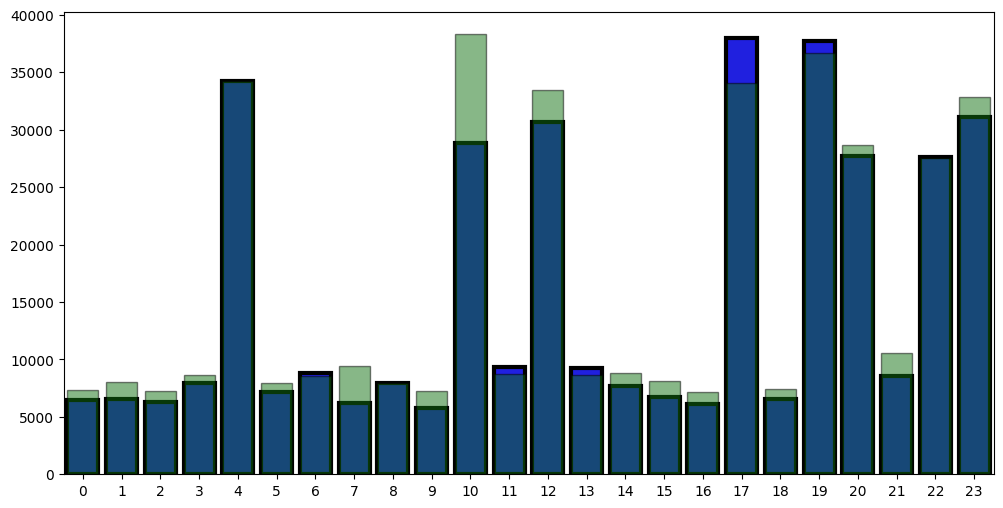

In [54]:
plt.figure(figsize=(12,6))
sns.barplot(np.array(y_test_low_values), color='blue', edgecolor='black', linewidth=3)
sns.barplot(model_rf_low_values_predict, color='green', alpha=0.5, edgecolor='black')

<Axes: >

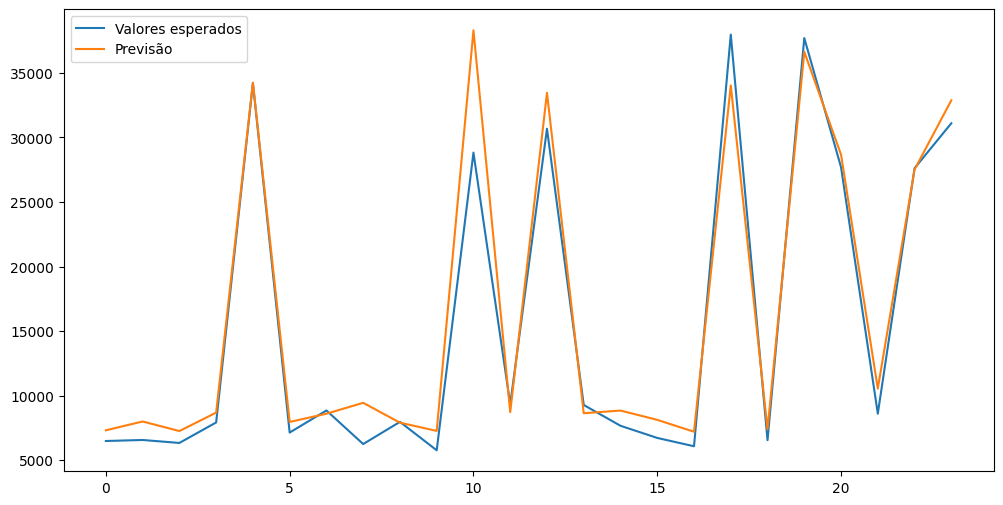

In [55]:
plt.figure(figsize=(12,6))
sns.lineplot(x=np.arange(0, len(y_test_low_values), 1), y=np.array(y_test_low_values), label='Valores esperados')
sns.lineplot(x=np.arange(0, len(y_test_low_values), 1), y=model_rf_low_values_predict, label='Previsão')

### Conclusão

No modelo considerando apenas valores de rendimentos baixos, por mais que o valor da métrica MSE abaixou, ainda temos muitos erros (principalmente, mais erros pra cima do que pra baixo). Considerando que estamos prevendo valores de rendimento de uma cultura, prever um valor muito alto quando na realidade o rendimento seria bem mais abaixo, pode ser um grande risco. Porém, nem tanto quanto um modelo prever abaixo do valor esperado, e na realidade o rendimento ser maior, isto não seria tão ruim, pois ainda seria um lucro.

Erros esperados:
- Errar abaixo do esperado.

Erros não aceitáveis:
- Errar acima do esperado.

Levando isto em consideração, o segundo modelo (que considera apenas culturas com rendimentos baixos) não desempenhou tão bem quanto o primeiro modelo (que considera todas as culturas), pois o segundo modelo, de certa forma, houve mais situações em que errou acima do esperado, onde o primeiro modelo teve menos situações como essa. 

Abaixo realizaremos alguns cálculos para verificar a quantidade de erros **acima do esperado** de cada um dos dois modelos:

In [56]:
rf_resid_low_values = model_rf_low_values_predict - y_test_low_values

In [57]:
print('Modelo considerando valores abaixo de 50 mil:')
print(f'Erros acima do esperado: {len(rf_resid_low_values[rf_resid_low_values > 0])} | {(len(rf_resid_low_values[rf_resid_low_values > 0]) * 100) / len(rf_resid_low_values):.2f}')
print(f'Total: {len(rf_resid_low_values)}')

Modelo considerando valores abaixo de 50 mil:
Erros acima do esperado: 17 | 70.83
Total: 24


In [58]:
print('Modelo considerando todas as culturas:')
print(f'Erros acima do esperado: {len(rf_resid[rf_resid > 0])} | {(len(rf_resid[rf_resid > 0]) * 100) / len(rf_resid):.2f}%')
print(f'Total: {len(rf_resid)}')

Modelo considerando todas as culturas:
Erros acima do esperado: 15 | 46.88%
Total: 32


### Treinando o melhor modelo

Iremos treinar o melhor modelo baseado nas métricas adquiridas no processo de validação cruzada. O algorítmo de **Floresta Aleatória** foi o melhor modelo.

In [59]:
# Modelos como o de floresta aleatória não é necessário normalizar os dados

final_model_rf = RandomForestRegressor(random_state=SEED)
final_model_rf.fit(X, y)

joblib.dump(final_model_rf, 'random_forest_model_all_crops.joblib')

['random_forest_model_all_crops.joblib']